# Flight Price Prediction #

## Introduction ##

This Notebook tries to find an answer to the question "What is the best time to book a flight?".
The dataset used in this notebook is provided by Prof. Dr. Martin Spott and Manu Mutthatu.
It contains flight data from 2019 for the following routes:
-   London Stansted and Berlin Schönefeld
-   London Stansted and Frankfurt

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve

## Get the data ##

In [2]:
# read in the data
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

## Explore the data (Data Exploration) ##

### Get to know the dataset ###

In [3]:
# make a copy of the data
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# check the data
df_train_copy.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


we can see that the data contains the following columns:
-   index: index of the row
-   request_date: date when the request was made
-   flight_date: date when the flight took place
-   departure_hour: hour when the flight departed
-   flight_unique_id: unique id for each flight
-   route_abb: abbreviation of the route
-   price_in_eur: price of the flight in euro
-   min_future_price_in_euro: minimum price of the flight in euro for all future request dates
-   buy: 1 if the flight should be bought, 0 if one should wait

In [4]:
# check the number of rows and columns
df_train_copy.shape

(83624, 9)

we can see that the data contains 83624 rows and 9 columns.

In [5]:
# check the data types
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    83624 non-null  int64  
 1   Request_Date             83624 non-null  object 
 2   Flight_Date              83624 non-null  object 
 3   Departure_hour           83624 non-null  int64  
 4   flight_unique_id         83624 non-null  object 
 5   route_abb                83624 non-null  object 
 6   Price_In_Eur             83624 non-null  float64
 7   min_future_price_in_Eur  83624 non-null  float64
 8   buy                      83624 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.7+ MB


we can see that the data types are correct, except for the date columns. We will deal with that later.

In [6]:
# check if there are any missing values
df_train_copy.isnull().sum()

index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64

There are no missing values in the data.

In [7]:
# check for duplicates
df_train_copy.duplicated().sum()

0

There are no duplicates in the data.

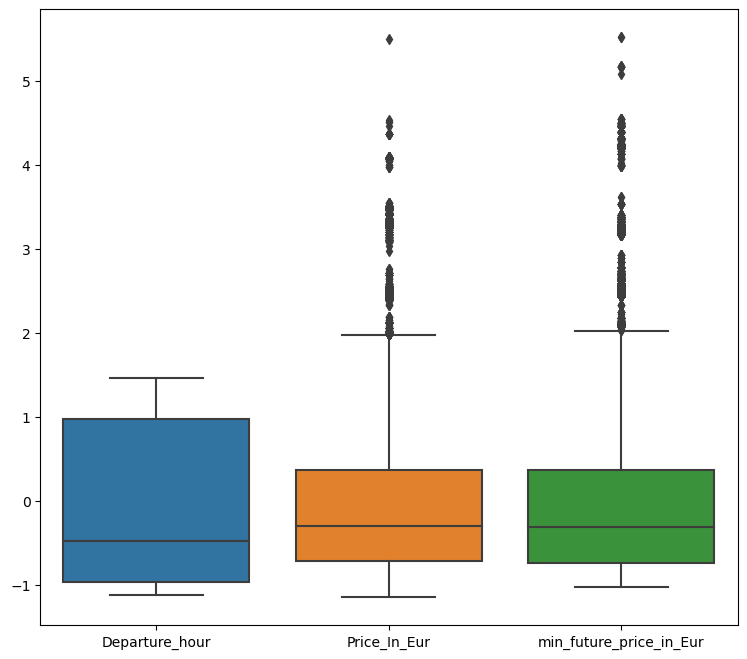

In [8]:
# Calculate z-scores for the numerical columns
df_train_num = df_train_copy[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']]
z_scores_train = stats.zscore(df_train_num)

# Calculate z-scores for the numerical columns
z_scores_test = stats.zscore(df_train_num[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']])

# Create Boxplots for the z-scores
plt.figure(figsize=(9, 8))
sns.boxplot(data=z_scores_train);

In [9]:
# Get the rows with z-scores > 3
outliers_train = np.where(z_scores_train > 3)

# Get the rows in the df_train_copy that contain outliers
df_train_copy_outlier_rows = df_train_copy.iloc[outliers_train[0]]
print(df_train_copy_outlier_rows)

# Check the proportion of outliers
print(len(df_train_copy_outlier_rows)/len(df_train_copy))

       index          Request_Date Flight_Date  Departure_hour  \
0          1  2019-06-03T11:00:00Z  2019-06-05              19   
1          2  2019-06-03T23:00:00Z  2019-06-05              19   
1          2  2019-06-03T23:00:00Z  2019-06-05              19   
2          3  2019-06-04T11:00:00Z  2019-06-05              19   
2          3  2019-06-04T11:00:00Z  2019-06-05              19   
...      ...                   ...         ...             ...   
71798  71799  2019-08-02T11:00:00Z  2019-09-01              18   
71799  71800  2019-08-02T23:00:00Z  2019-09-01              18   
71799  71800  2019-08-02T23:00:00Z  2019-09-01              18   
71800  71801  2019-08-03T11:00:00Z  2019-09-01              18   
71800  71801  2019-08-03T11:00:00Z  2019-09-01              18   

        flight_unique_id route_abb  Price_In_Eur  min_future_price_in_Eur  buy  
0      2019-06-05 FR 146   SXF-STN        208.07                   259.07    1  
1      2019-06-05 FR 146   SXF-STN        259

In [10]:
# Check the distribution of the route_abb column for the outliers
df_train_copy_outlier_rows['route_abb'].value_counts()

STN-SXF    1899
SXF-STN    1479
STN-FRA     393
FRA-STN     318
Name: route_abb, dtype: int64

In [11]:
# Check the distribution of Departure_hour column for the outliers
df_train_copy_outlier_rows['Departure_hour'].value_counts()

19    1247
6      767
18     667
7      666
10     349
22     285
8       68
21      40
Name: Departure_hour, dtype: int64

There are a few outliers in the data. But it seems that the outliers are not random but are associated with specific routes and departure hours. This suggests that they might be extreme but valid data points. Therefore we will not remove or replace them.

In [12]:
# check the noise in the data
df_train_copy.describe()

,index,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy
count,83624.000000,83624.000000,83624.000000,83624.000000,83624.000000
mean,41812.500000,12.969889,71.965080,56.593014,0.223835
std,24140.313792,6.177936,54.788483,46.126909,0.416815
min,1.000000,6.000000,8.990000,8.990000,0.000000
25%,20906.750000,7.000000,32.770000,22.270000,0.000000
50%,41812.500000,10.000000,55.080000,41.890000,0.000000
75%,62718.250000,19.000000,91.790000,73.430000,0.000000
max,83624.000000,22.000000,372.960000,311.090000,1.000000


-  Departure_hour: earliest departure hour is 6 (6 am), latest departure hour is 22 (10pm). Man is 13 (1 pm).
-  Price_In_Eur: minimum price is 8.99€, maximum price is 372.96€. Average price is 72€.
-  Min_future_price_in_euro: minimum minimum future price is 8.99€, maximum minimum future price is 311.09€. Average minimum future price is 57€.

### Price in Eur ###

88.73     2531
73.43     2316
106.07    1840
45.89     1735
19.99     1545
          ... 
62.99        1
123.22       1
173.10       1
205.65       1
59.70        1
Name: Price_In_Eur, Length: 2868, dtype: int64


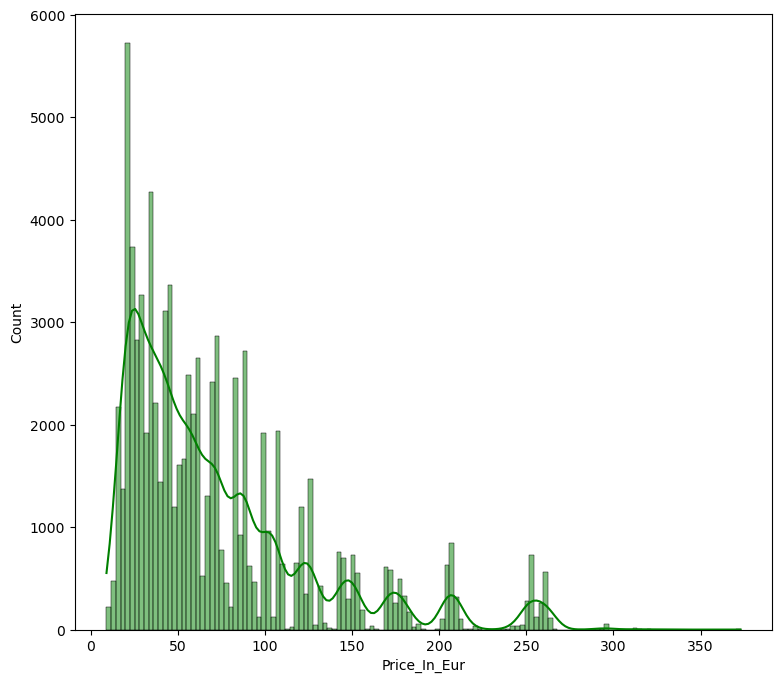

In [13]:
# check the distribution of Price in Euro
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Price_In_Eur'], color='g', kde=True);

# check the most common price
print(df_train_copy['Price_In_Eur'].value_counts())


The prices seem to be quite evenly distributed. There are fluctuations in the higher prices that seem to be repeated. Also there seems to be some outliers in prices around and above 350€.

### Min Future Price in Euro ###

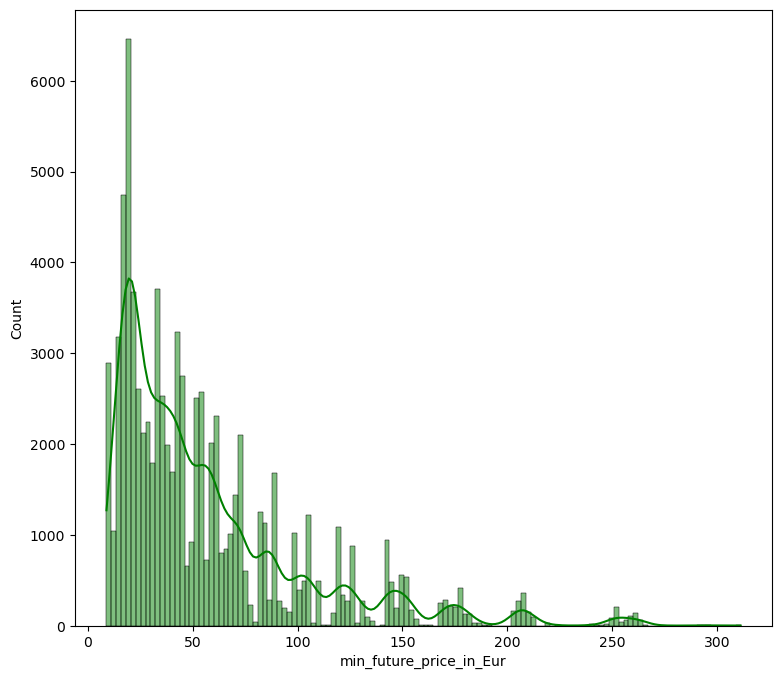

In [14]:
# check distribution of min_future_price_in_eur
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['min_future_price_in_Eur'], color='g', kde=True);

### Request Date ###

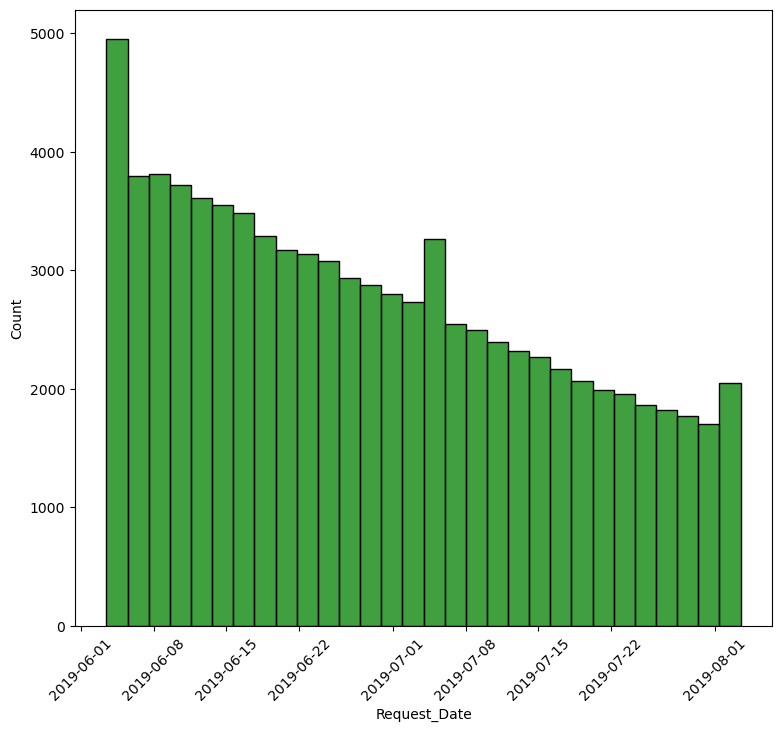

In [15]:
# check the distribution of the request date
# convert the request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Request_Date'], color='g', bins=30);

# rotate the x axis value description to make it more readable
plt.xticks(rotation=45);

# make a more useful plot for the request date
# df_train_copy['Request_Date'].value_counts().plot(figsize=(9, 8));

In [16]:
# check for outliers in request date
print(df_train_copy[df_train_copy['Request_Date'] < '2019-01-01'].shape[0])

# check the last date in the data
print(df_train_copy['Request_Date'].min())
print(df_train_copy['Request_Date'].max())

0
2019-06-03 11:00:00+00:00
2019-08-03 11:00:00+00:00


The data contains requests from 2019-06-03 to 2019-08-03. There are no outliers in the request date.

In [17]:
# check the last request date for each flight
df_train_copy.groupby('flight_unique_id')['Request_Date'].max()

flight_unique_id
2019-06-05 FR 146    2019-06-04 23:00:00+00:00
2019-06-05 FR 147    2019-06-04 23:00:00+00:00
2019-06-05 FR 8545   2019-06-04 23:00:00+00:00
2019-06-06 FR 144    2019-06-05 11:00:00+00:00
2019-06-06 FR 146    2019-06-05 23:00:00+00:00
                                ...           
2019-09-09 FR 8545   2019-08-03 11:00:00+00:00
2019-09-10 FR 144    2019-08-03 11:00:00+00:00
2019-09-10 FR 145    2019-08-03 11:00:00+00:00
2019-09-10 FR 8542   2019-08-03 11:00:00+00:00
2019-09-10 FR 8543   2019-08-03 11:00:00+00:00
Name: Request_Date, Length: 1007, dtype: datetime64[ns, UTC]

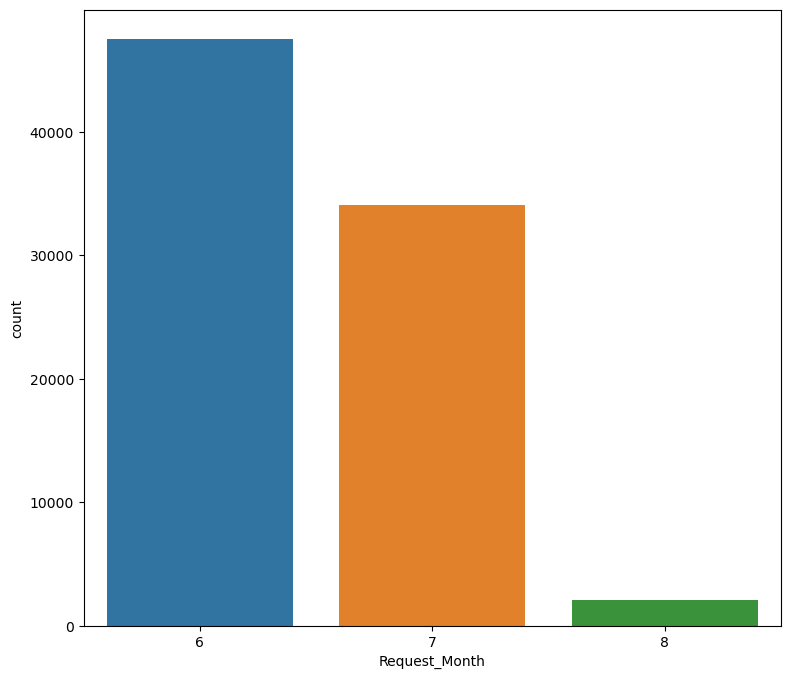

In [18]:
# Extract the month from the request date
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

# plot the request month
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Month', data=df_train_copy);

The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August.

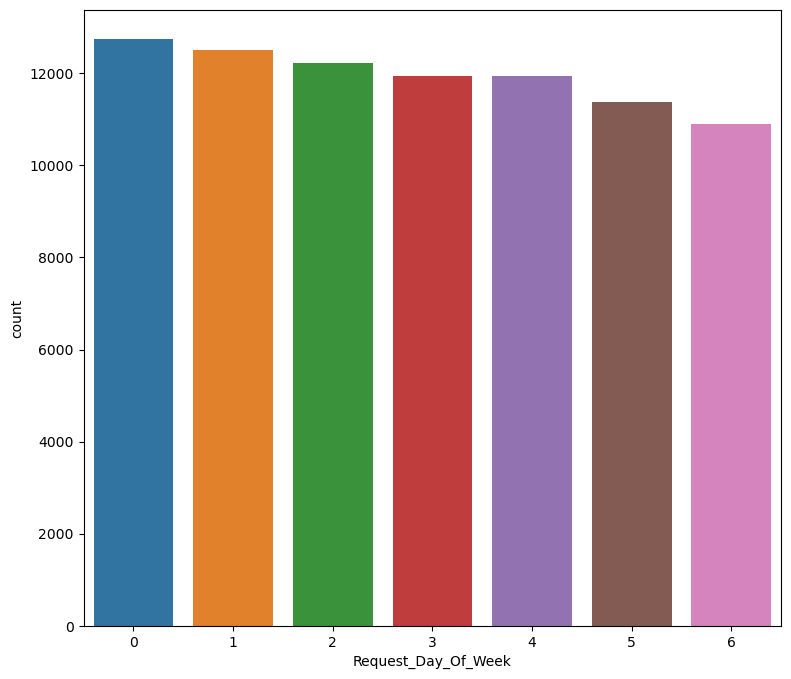

In [19]:
# Extract the day of the week from the request date
df_train_copy['Request_Day_Of_Week'] = df_train_copy['Request_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the request day of the week
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Day_Of_Week', data=df_train_copy);

There are nearly the same amount of requests on each day of the week.

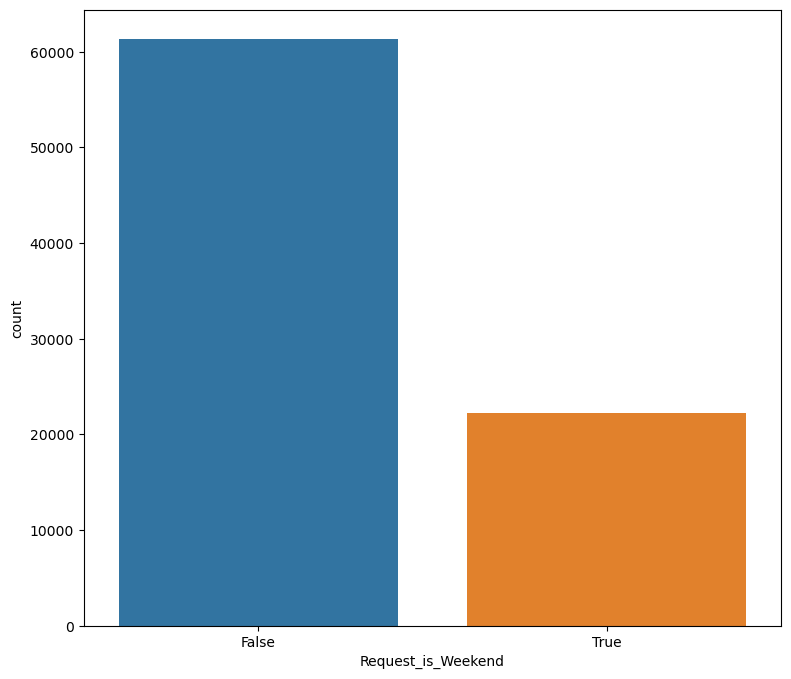

In [20]:
# create a new column to indicate if the request was made on a weekend
df_train_copy['Request_is_Weekend'] = df_train_copy['Request_Date'].dt.weekday >= 5

# plot the request is weekend
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_is_Weekend', data=df_train_copy);

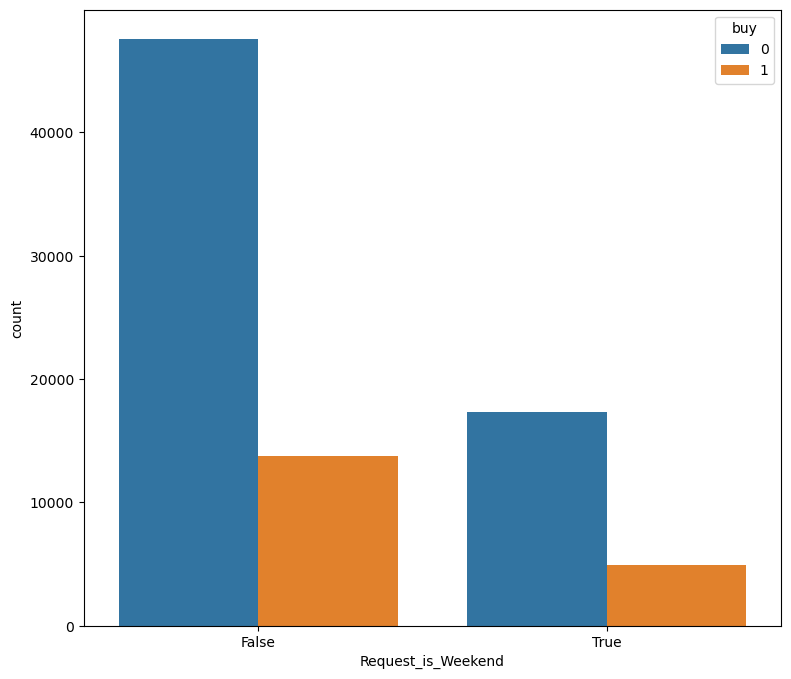

In [21]:
# plot Request_is_Weekend with buy
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_is_Weekend', hue='buy', data=df_train_copy);

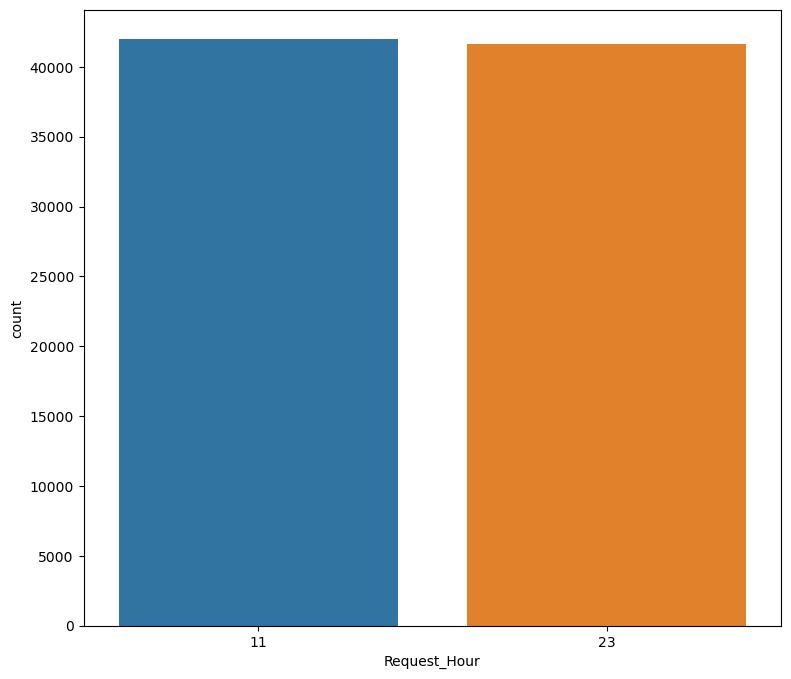

In [22]:
# extract the hour from the request date
df_train_copy['Request_Hour'] = df_train_copy['Request_Date'].dt.hour

# plot the request hour
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Hour', data=df_train_copy);

There were requests only at 11 (11 am) and at 23 (11 pm).

### Flight Date ###

2019-06-05 00:00:00
2019-09-10 00:00:00
[]


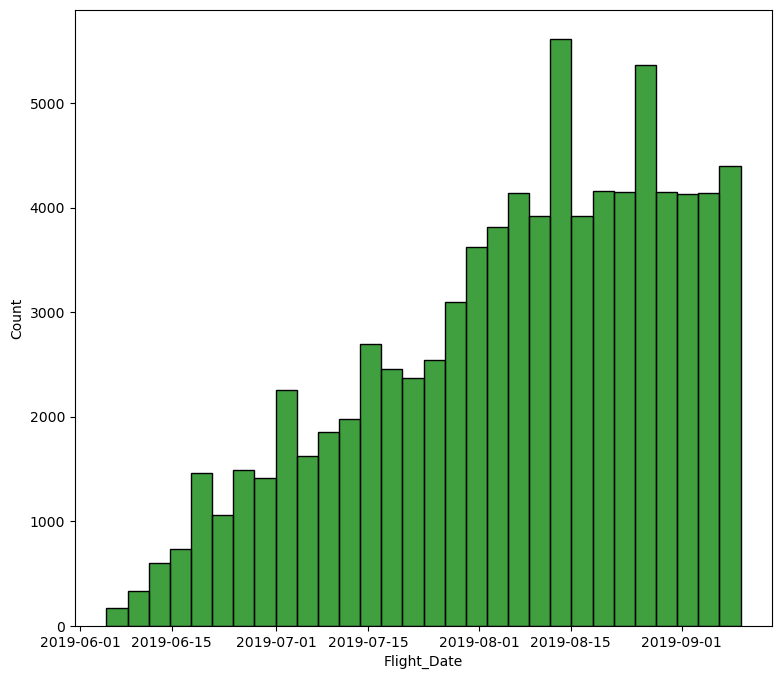

In [23]:
# check the distribution of flight date
# convert the flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Flight_Date'], color='g', bins=30);

# make a more useful plot for the flight date
# df_train_copy['Flight_Date'].value_counts().plot(figsize=(9, 8));

# get the first and the last flight date
print(df_train_copy['Flight_Date'].min())
print(df_train_copy['Flight_Date'].max())

# find dates in the data where no flight was scheduled
# create a list of dates in the date range
date_range = pd.date_range(start=df_train_copy['Flight_Date'].min(), end=df_train_copy['Flight_Date'].max())

# create a list of dates in flight date
flight_date = df_train_copy['Flight_Date'].unique()

# find the dates in the date range that are not in flight date
date_not_in_flight_date = [date for date in date_range if date not in flight_date]
print(date_not_in_flight_date)

The first flight left on 2019-06-05 and the last flight on 2019-09-10. On each day a flight was scheduled. There are no outliers in the flight date.

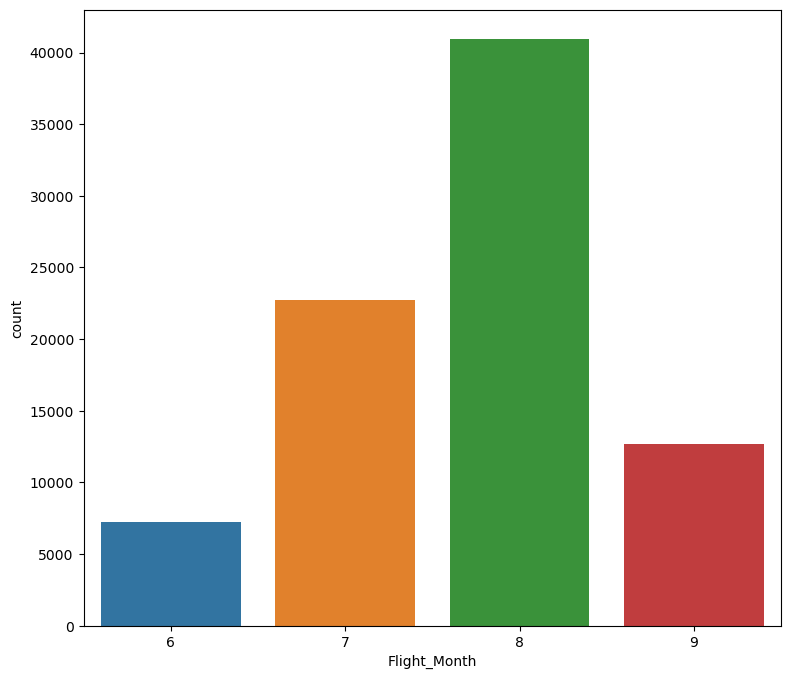

In [24]:
# Extract the month from the flight date
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

# plot the flight month
plt.figure(figsize=(9, 8))
sns.countplot(x='Flight_Month', data=df_train_copy);

Most flights depart in August, around half as many in July and only a few in September and even less in June.

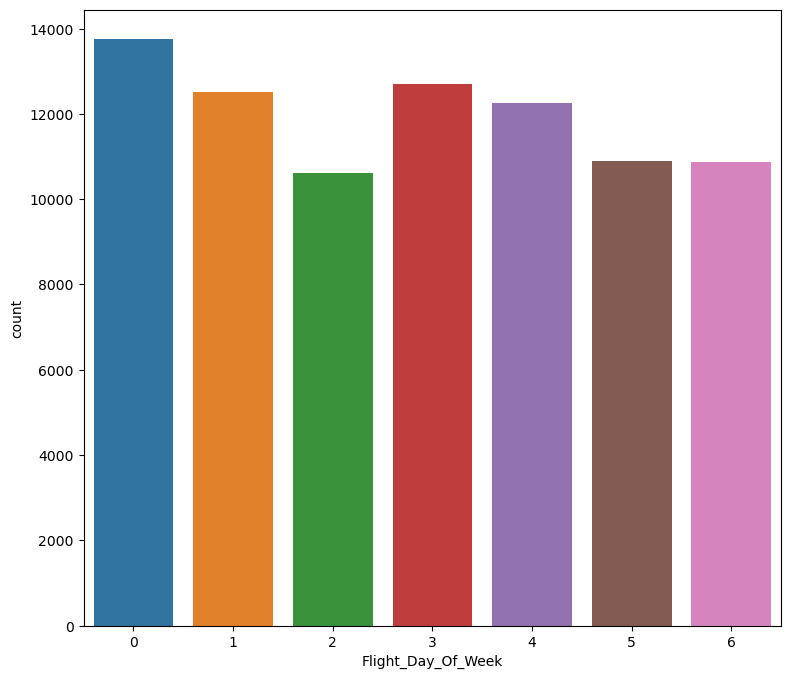

In [25]:
# Extract the day of the week from the flight date
df_train_copy['Flight_Day_Of_Week'] = df_train_copy['Flight_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the flight day of the week
plt.figure(figsize=(9, 8))
sns.countplot(x='Flight_Day_Of_Week', data=df_train_copy);

In [26]:
# check data types of flight date and request date
print(df_train_copy['Flight_Date'].dtype)
print(df_train_copy['Request_Date'].dtype)

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# check dates, where the flight date is before the request date
flight_date_before_request_date = df_train_copy[df_train_copy['Flight_Date'] < df_train_copy['Request_Date']]

print(flight_date_before_request_date.shape[0])

datetime64[ns]
datetime64[ns, UTC]
0


There are no Flights where the flight date is before the request date.

#### New Feature: Days between request date and flight date ####

count    83624.000000
mean        37.913601
std         22.859873
min          0.000000
25%         19.000000
50%         36.000000
75%         55.000000
max         98.000000
Name: days_between_request_and_flight, dtype: float64


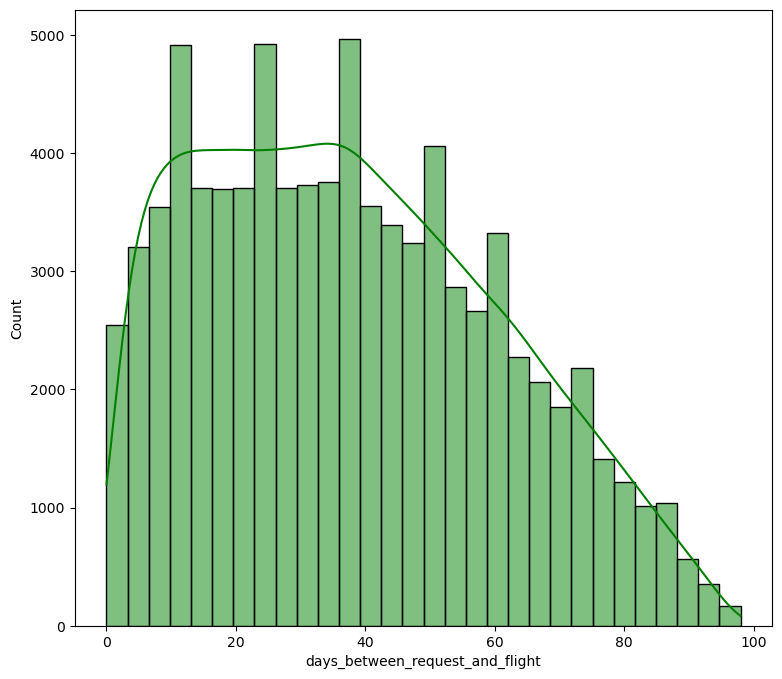

In [27]:
# check the distribution of the number of days between request date and flight date
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['days_between_request_and_flight'], color='g', kde=True, bins=30);

# get the min, max, mean and median of the number of days between request date and flight date
print(df_train_copy['days_between_request_and_flight'].describe())

### Departure Hour ###

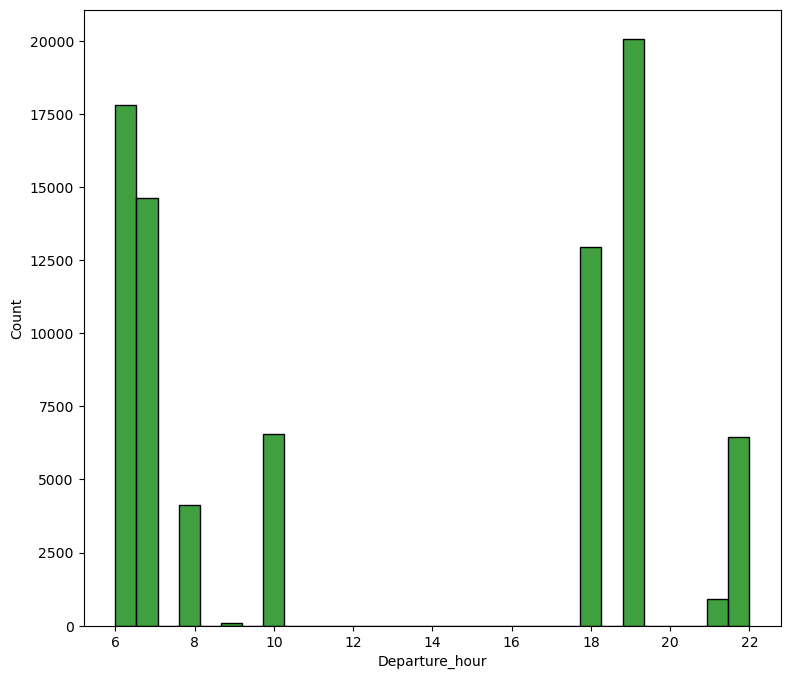

In [28]:
# check the distribution of Departure hour
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Departure_hour'], color='g');

In [29]:
# check the amounts of data with Departure hour between 12 and 16
df_train_copy[(df_train_copy['Departure_hour'] >= 12) & (df_train_copy['Departure_hour'] <= 16)].shape[0]

0

The earliest flights depart at 6, the latest at 22. Most flights seem to depart in the morning or in the evening. There are no flights departing in the afternoon between 12 and 16.

### New Feature: Is Holiday ###

As it is possible that the price of flights is higher on bank holidays or during school holidays, a new feature is added to the data: is_holiday. 

#### Bank Holidays ####

The data for the bank holidays is taken from https://pypi.org/project/holidays/. The data contains bank holidays for different countries. The data for holidays in germany and uk is then merged with the data from the flights.

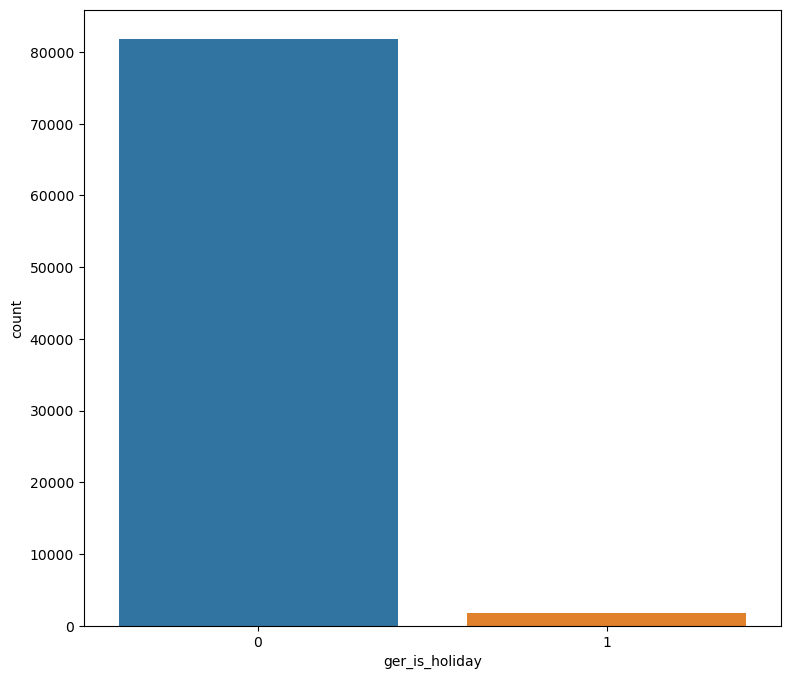

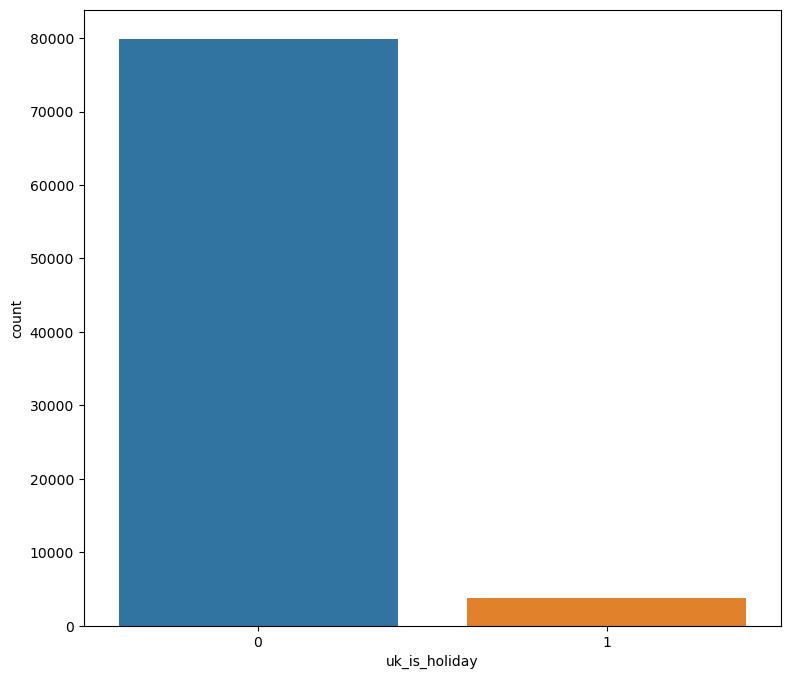

In [30]:
from datetime import date
import holidays

ger_holidays = holidays.GR()
# create a function to check if a date is a holiday in germany
def is_holiday_ger(date):
    if date in ger_holidays:
        return 1
    else:
        return 0
    
# create a new column with the holiday information
df_train_copy['ger_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_ger)

# check the distribution of is_holiday
plt.figure(figsize=(9, 8)) 
sns.countplot(x='ger_is_holiday', data=df_train_copy);


uk_holidays = holidays.UK()
# create a function to check if a date is a holiday in the UK
def is_holiday_uk(date):
    if date in uk_holidays:
        return 1
    else:
        return 0

# create a new column with the holiday information
df_train_copy['uk_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_uk)

# check the distribution of is_holiday
plt.figure(figsize=(9, 8))
sns.countplot(x='uk_is_holiday', data=df_train_copy);

Because there are only a few holidays in the data, the two holiday columns are combined to one column. The new column contains the information if the flight is on a holiday (it doesn't matter if in the departure or arrival country) or not.

In [31]:
# define a function to check if a date is a holiday in the UK or Germany
def is_holiday_uk_ger(date):
    if date in ger_holidays or date in uk_holidays:
        return 1
    else:
        return 0

In [32]:
# merge the two holiday columns into one
df_train_copy['is_holiday'] = df_train_copy['ger_is_holiday'] + df_train_copy['uk_is_holiday']

# drop the two holiday columns
df_train_copy.drop(['ger_is_holiday', 'uk_is_holiday'], axis=1, inplace=True)

TODO: Extended bank holidays to include the days before and after the bank holidays. This is done because it is possible that the prices are higher on the days before and after the bank holidays.

#### School holidays ####

Flight prices may be higher during the school holidays, because more people have the opportunity to go on vacation. Because the flights arrival and departure airports are in Germany and UK, the school holidays for these countries are added to the data. Because in Germany the school holidays are different for each state, the school holidays for the state of the departure airport are added to the data, meaning Berlin (and Brandenburg because it is close to Berlin) and Nordrhein-Westfalen (NRW). Only if the flight is in the school holidays of the departure or arrival airport, the flight is marked as a flight during the school holidays.
 The school holidays are taken from following websites:
-  NRWhttps://www.schulferien.org/deutschland/ferien/2019/ (visited 10.07.2023)
-  https://world-schools.com/de/school-holidays-in-the-uk-in-2019/ (visited 10.07.2023)

Index(['index', 'Request_Date', 'Flight_Date', 'Departure_hour',
       'flight_unique_id', 'route_abb', 'Price_In_Eur',
       'min_future_price_in_Eur', 'buy', 'Request_Month',
       'Request_Day_Of_Week', 'Request_is_Weekend', 'Request_Hour',
       'Flight_Month', 'Flight_Day_Of_Week', 'days_between_request_and_flight',
       'is_holiday'],
      dtype='object')


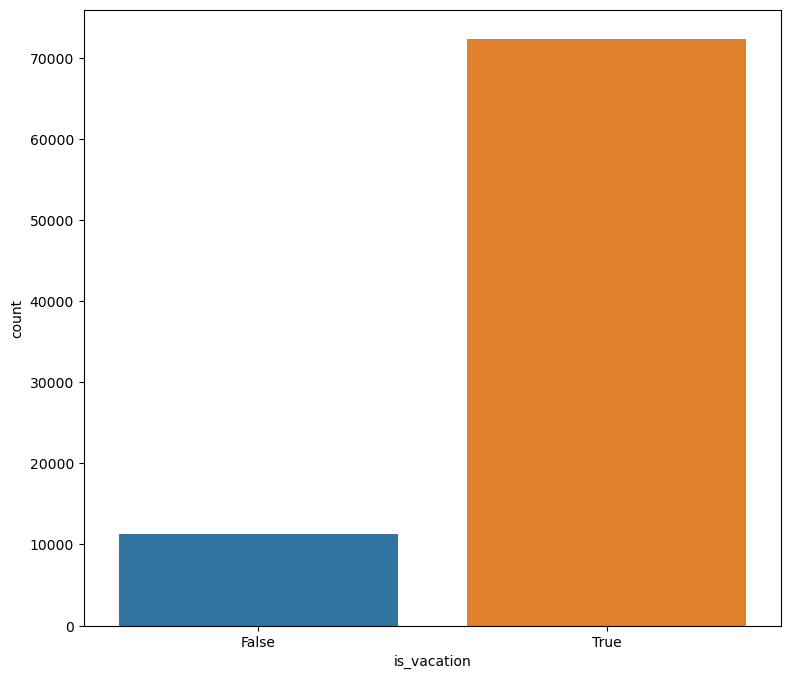

In [33]:
print(df_train_copy.columns)
# add school holidays of NRW, Berlin, Brandenburg and England
# Define the vacation periods with associated airports
vacations = [
    {'start': '2019-07-15', 'end': '2019-08-27', 'airports': ['FRA']},  # NRW
    {'start': '2019-05-31', 'end': '2019-06-11', 'airports': ['SXF']},  # Berlin
    {'start': '2019-06-20', 'end': '2019-08-02', 'airports': ['SXF']},  # Berlin
    {'start': '2019-06-20', 'end': '2019-08-03', 'airports': ['SXF']},  # Brandenburg
    {'start': '2019-07-15', 'end': '2019-09-06', 'airports': ['STN']}   # England
]

# Convert the start and end dates to datetime
for vacation in vacations:
    vacation['start'] = pd.to_datetime(vacation['start'])
    vacation['end'] = pd.to_datetime(vacation['end'])

# Extract the Departure_airport and Arrival_airport from the route_abb column
df_train_copy['departure_airport'] = df_train_copy['route_abb'].str[:3]
df_train_copy['arrival_airport'] = df_train_copy['route_abb'].str[-3:]

# Initialize a new column 'is_vacation' with False
df_train_copy['is_vacation'] = False

# Set 'is_vacation' to True if the flight date is within any of the vacation periods and the origin or destination airport is associated with the vacation
for vacation in vacations:
    df_train_copy.loc[(df_train_copy['Flight_Date'] >= vacation['start']) & (df_train_copy['Flight_Date'] <= vacation['end']) & ((df_train_copy['departure_airport'].isin(vacation['airports'])) | (df_train_copy['arrival_airport'].isin(vacation['airports']))), 'is_vacation'] = True

# Display the first few rows of the dataframe
df_train_copy.head()

# drop the departure and arrival airport columns
df_train_copy.drop(['departure_airport', 'arrival_airport'], axis=1, inplace=True)

# plot the distribution of is_vacation
plt.figure(figsize=(9, 8))
sns.countplot(x='is_vacation', data=df_train_copy);

#### Merge bank holidays and school holidays ####

In [34]:
# merge the columns 'is_holiday' and 'is_vacation' into one column
df_train_copy['is_holiday'] = df_train_copy['is_holiday'] + df_train_copy['is_vacation']

# drop the column 'is_vacation'
df_train_copy.drop('is_vacation', axis=1, inplace=True)

### Route Abb ###

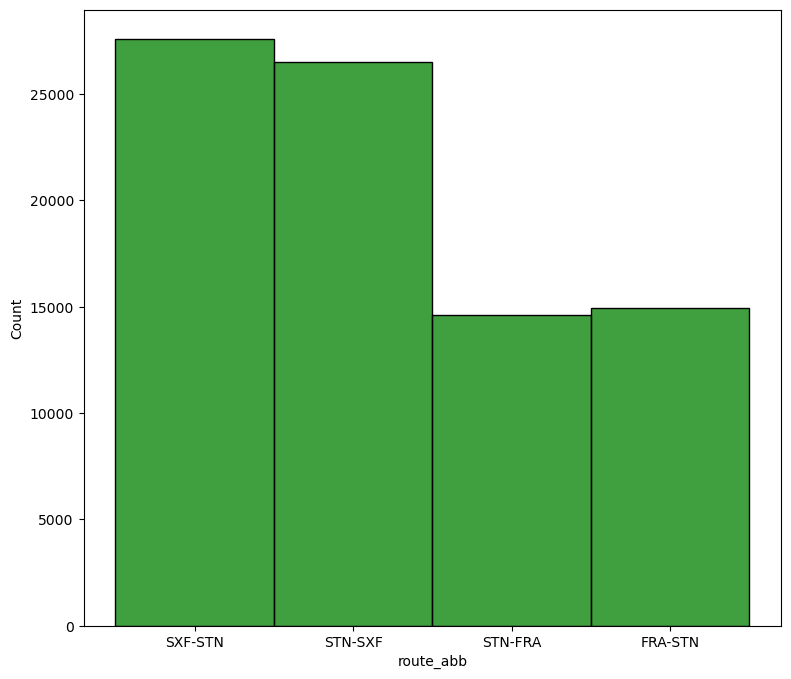

In [35]:
# check the distribution of route abb
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['route_abb'], color='g');

The data contains 2 routes: SXF-STN and STN-FRA additionally for both of those routes there are flights in both directions. There are a little more than 10000 more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA.

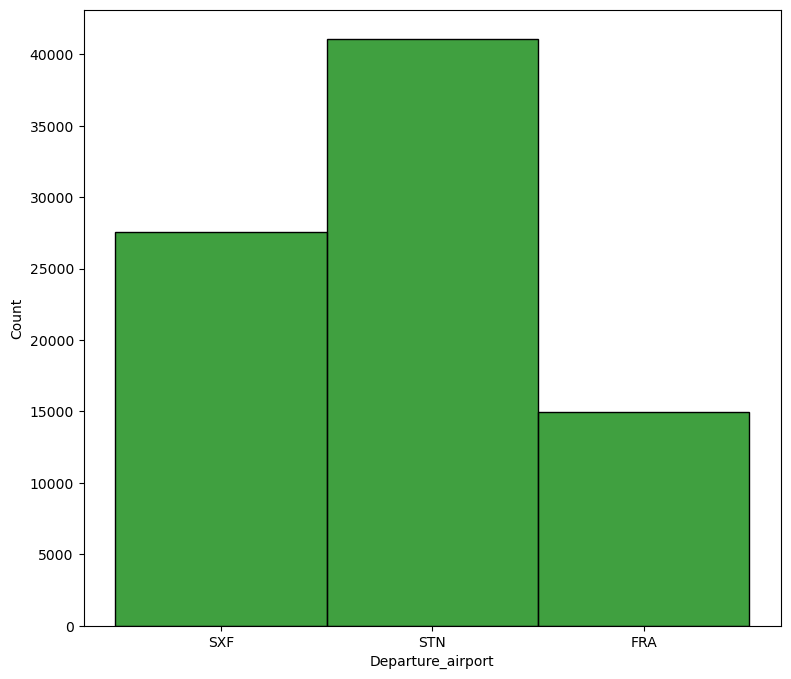

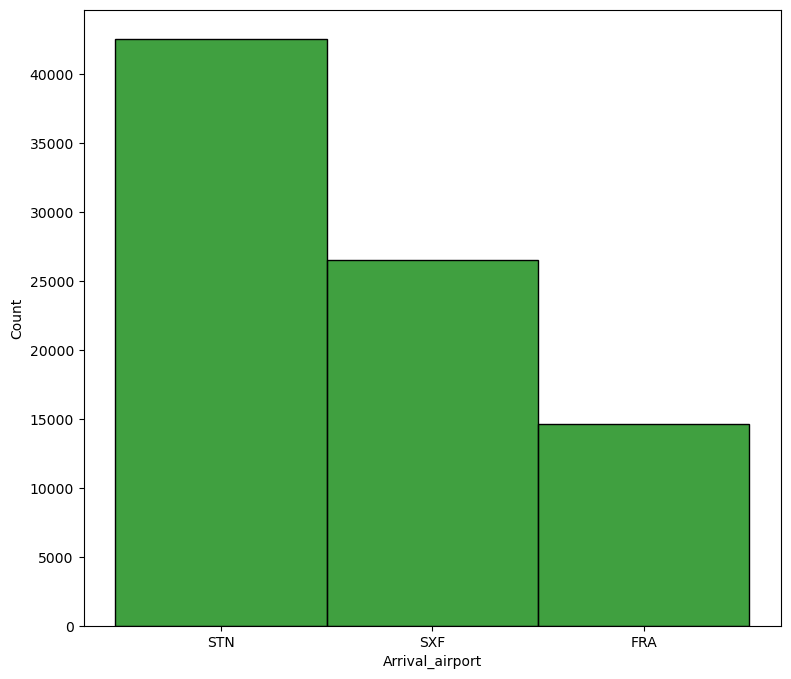

In [36]:
# Extract the departure and arrival airports from the route_abb column
df_train_copy['Departure_airport'] = df_train_copy['route_abb'].str.split('-').str[0]
df_train_copy['Arrival_airport'] = df_train_copy['route_abb'].str.split('-').str[1]

# check the distribution of Departure airport
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Departure_airport'], color='g');

# check the distribution of Arrival airport
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Arrival_airport'], color='g');

### Buy ###

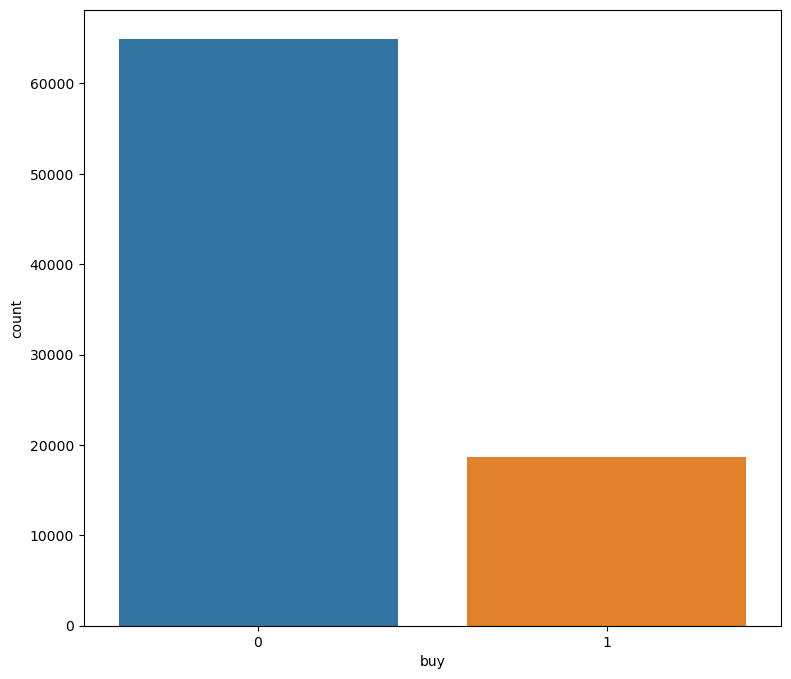

In [37]:
# check the distribution of buy
plt.figure(figsize=(9, 8))
sns.countplot(x='buy', data=df_train_copy);

There are more than three times more requests where the flight is currently not recommended to be bought than requests where the flight is recommended to be bought.

There are between 0 and 98 days between the request date and the flight date.

### Flight Unique Id ###

1007


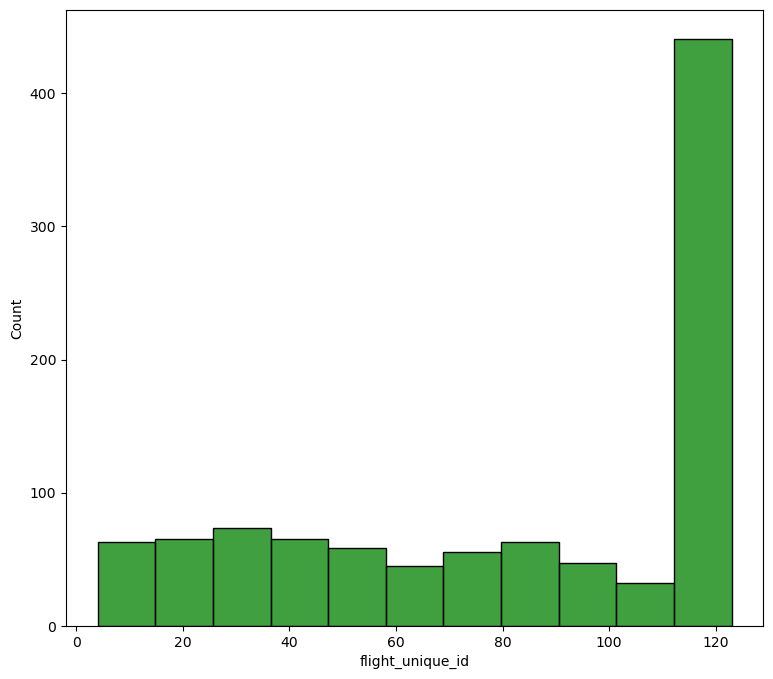

In [38]:
# check how many different flights are in the data
print(df_train_copy['flight_unique_id'].nunique())

# plot the number of requests for each flight
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['flight_unique_id'].value_counts(), color='g');

### New Feature: Current Price Trend ###

The current price trend may be a relevant information. If the price is currently rising, it may be better to buy the flight now. If the price is currently falling, it may be better to wait a little longer.

In [39]:
# function to calculate the current price trend
def price_trend(df):
    # calculate the rolling average of the last 3 prices for each flight
    df['rolling_mean_price'] = df.groupby('flight_unique_id')['Price_In_Eur'].rolling(window=3).mean().reset_index(0, drop=True)

    # calculate the price difference between the current price and the rolling average price
    df['avg_price_difference'] = df['Price_In_Eur'] - df['rolling_mean_price']

    # create a new column 'avg_price_trend' based on the sign of the 'avg_price_difference'
    # positive difference indicates an upward trend (1), negative difference indicates a downward trend (-1) an zero indicates a stable trend (0)
    df['price_trend'] = df['avg_price_difference'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # replace the NaN values in the 'avg_price_trend' column with 0
    df['price_trend'] = df['price_trend'].fillna(0)

    # drop the 'rolling_mean_price' and 'avg_price_difference' columns
    df = df.drop(['rolling_mean_price', 'avg_price_difference'], axis=1)

price_trend(df_train_copy)
# drop 'rolling_mean_price' and 'avg_price_difference'
df_train_copy.drop(['rolling_mean_price', 'avg_price_difference'], axis=1, inplace=True)
print(df_train_copy.columns)

Index(['index', 'Request_Date', 'Flight_Date', 'Departure_hour',
       'flight_unique_id', 'route_abb', 'Price_In_Eur',
       'min_future_price_in_Eur', 'buy', 'Request_Month',
       'Request_Day_Of_Week', 'Request_is_Weekend', 'Request_Hour',
       'Flight_Month', 'Flight_Day_Of_Week', 'days_between_request_and_flight',
       'is_holiday', 'Departure_airport', 'Arrival_airport', 'price_trend'],
      dtype='object')


### Summary ###

The distribution of the number of requests per flight shows that a small number of flights account for a disproportionately high share of total requests, while the majority of flights receive only a small number of requests.

The data exploration so far showed that:
-  There are no duplicates in the data
-  There are no missing values in the data
-  *Request_date* and *Flight_date* are of type object, but should be of type datetime. Request date contained the timezone information, which was removed. The data was then converted to datetime.
-  *Price_In_Eur*:
    -  The distribution is right-skewed, with most of the flight prices being less than 100 EUR. There are also some flights with prices up to around 375 EUR, but these are less common.
-  *Min_future_price_in_Eur*:
    -  The distribution is similar to that of 'Price_In_Eur', being right-skewed with most of the minimum future prices being less than 100 EUR. There are also some flights with minimum future prices up to around 300 EUR, but these are less common.
-  *Request_Date*:
    -  the data contains *Request_date*s from 2019-06-03 to 2019-08-03. There are no outliers. <br>
    The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August. <br>
    There are nearly the same amount of requests on each day of the week. There are no outliers.
-  *Flight_Date*:
    -  the first *Flight_date* is on 2019-06-05 and the last flight on 2019-09-10. There are no outliers.
-  *Departure_hour*:
    -  the flights depart between 6 and 22, most of them in the morning or in the evening, none between 12 and 16. There are no outliers.
-  *Route_abb*:
    -  the data contains 2 routes in *route_abb* with flights in both directions, so 4 routes: SXF-STN and STN-FRA. There are around 1.5 times more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA. There are no outliers.
-  *Buy*:
    -  there are more than three times more flights that currently are recommended not to *buy* than flights that should be bought.
-  *Flight_unique_id*:
    -  the distribution of the number of requests per flight shows that a small number of flights account for a disproportionately high share of total requests, while the majority of flights receive only a small number of requests.

### Looking for Correlations ###

Check for correlation between the variables. Because min_future_price_in_eur or buy are the target variables, we will now check for correlation between them and the other variables. min_future_price_in_eur or buy are the target variables we may want to predict, because we want to predict if a customer currently should buy a flight or not or a company now should give a reccomendation to buy a flight or not. If we learn to predict the minimum future price, we can use this to say if a flight should currently be bought or if it gets cheaper in the future. If we learn to predict if a flight should currently be bought (meaning target variable buy), we can use this to directly give a recommendation to buy a flight or not.

In [40]:
# print the column names
print(df_train_copy.columns)

Index(['index', 'Request_Date', 'Flight_Date', 'Departure_hour',
       'flight_unique_id', 'route_abb', 'Price_In_Eur',
       'min_future_price_in_Eur', 'buy', 'Request_Month',
       'Request_Day_Of_Week', 'Request_is_Weekend', 'Request_Hour',
       'Flight_Month', 'Flight_Day_Of_Week', 'days_between_request_and_flight',
       'is_holiday', 'Departure_airport', 'Arrival_airport', 'price_trend'],
      dtype='object')


In [41]:
# check the correlation between the features and the target variable 'buy'
corr_matrix = df_train_copy.corr()
corr_matrix['buy'].sort_values(ascending=False)

buy                                1.000000
min_future_price_in_Eur            0.197882
Request_Month                      0.095869
Request_Day_Of_Week                0.022429
Departure_hour                    -0.000522
Request_is_Weekend                -0.002159
Flight_Day_Of_Week                -0.014860
Request_Hour                      -0.020099
is_holiday                        -0.033718
Price_In_Eur                      -0.038199
price_trend                       -0.104632
Flight_Month                      -0.117909
index                             -0.121130
days_between_request_and_flight   -0.224999
Name: buy, dtype: float64

In [42]:
# check the correlation between the features and the target variable 'min_future_price_in_Eur'
corr_matrix = df_train_copy.corr()
corr_matrix['min_future_price_in_Eur'].sort_values(ascending=False)

min_future_price_in_Eur            1.000000
Price_In_Eur                       0.894554
buy                                0.197882
Request_Month                      0.177996
Flight_Day_Of_Week                 0.097273
Departure_hour                     0.083496
price_trend                        0.055918
Request_Day_Of_Week                0.007517
is_holiday                        -0.004934
Request_is_Weekend                -0.005590
Request_Hour                      -0.008186
Flight_Month                      -0.395865
index                             -0.409284
days_between_request_and_flight   -0.563969
Name: min_future_price_in_Eur, dtype: float64

#### Scatterplot ####

Scatterplot to look for conspicuities of the most correlated features in the data.

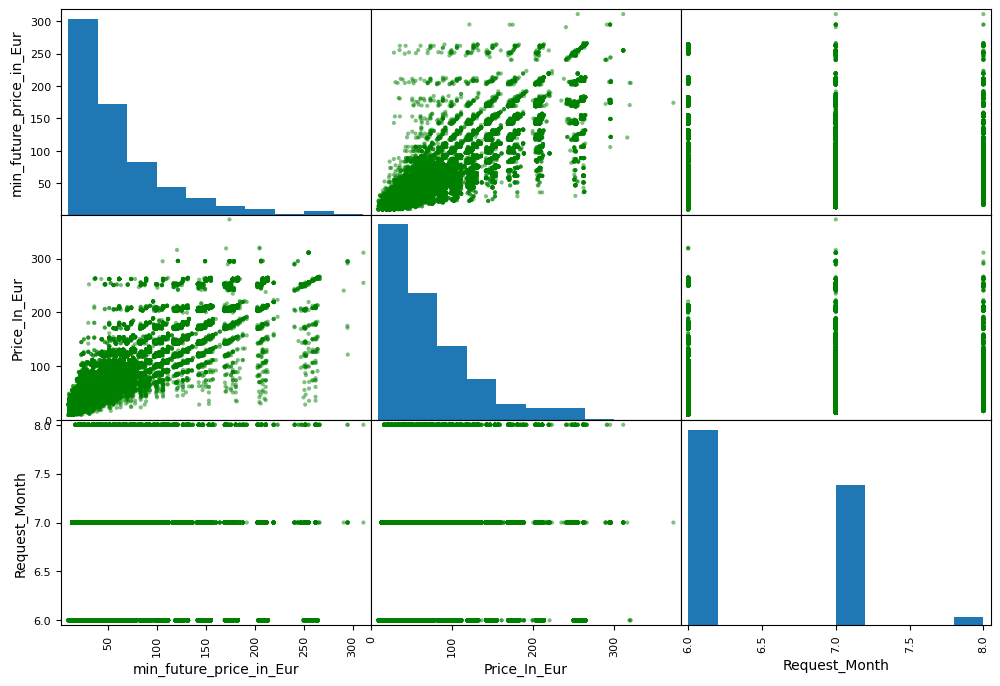

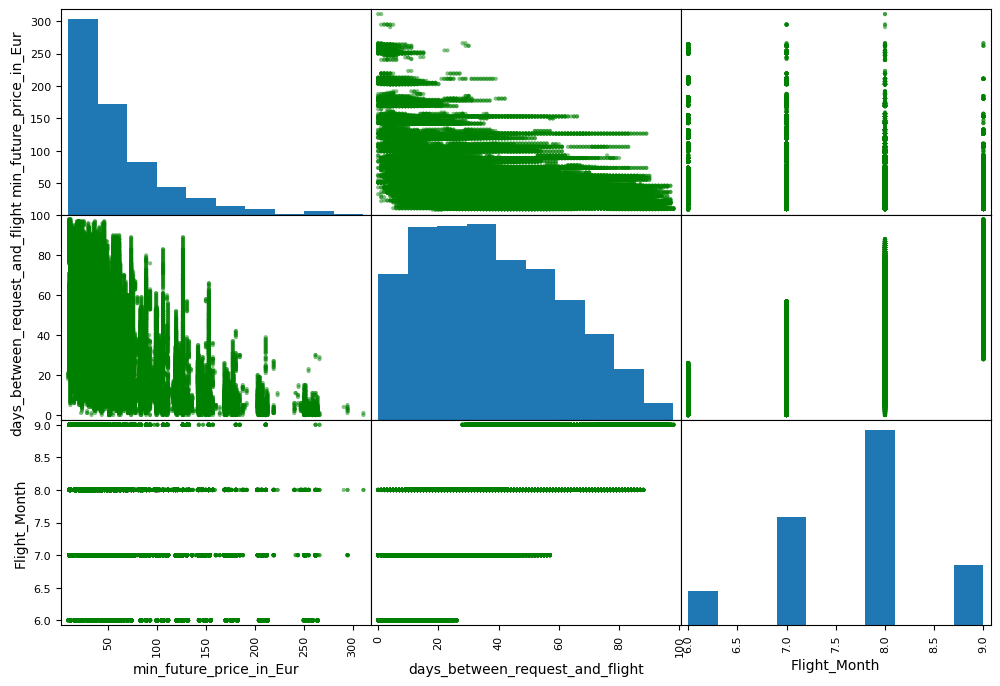

In [43]:
# plot the scatter matrix for min_future_price_in_Eur and the features with the highest correlation
attributes = ['min_future_price_in_Eur', 'Price_In_Eur', 'Request_Month']
scatter_matrix(df_train_copy[attributes], figsize=(12, 8), color='g');

attributes = ['min_future_price_in_Eur', 'days_between_request_and_flight', 'Flight_Month']
scatter_matrix(df_train_copy[attributes], figsize=(12, 8), color='g');

#### Correlation Matrix ####

Correlation matrix to look for correlations between the features and the target variables.

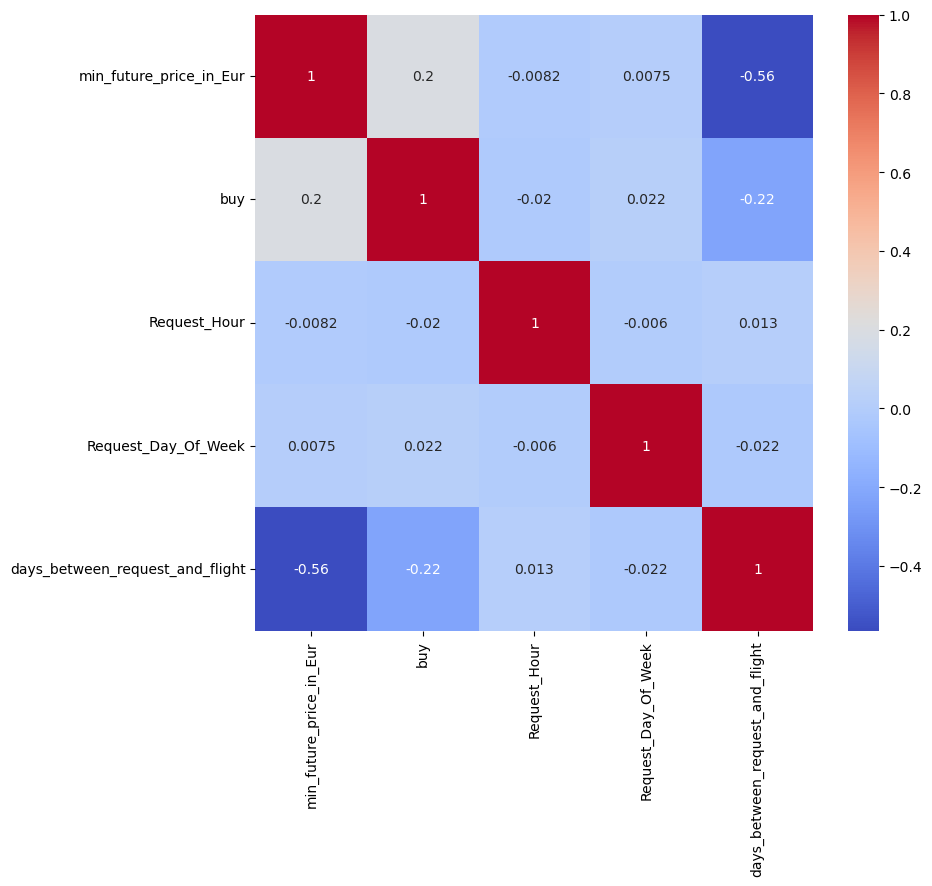

In [44]:
# Correlation matrix for min_future_price_in_eur, buy and the request related columns
corr_matrix = df_train_copy[['min_future_price_in_Eur', 'buy', 'Request_Hour', 'Request_Day_Of_Week', 'days_between_request_and_flight']].corr()

# plot the correlation matrix
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

-  -0.56 (strong negativ correlation): min_future_price_in_eur and days_between_request_and_flight_date
-  -0.22 (negativ correlation): buy and days_between_request_and_flight_date

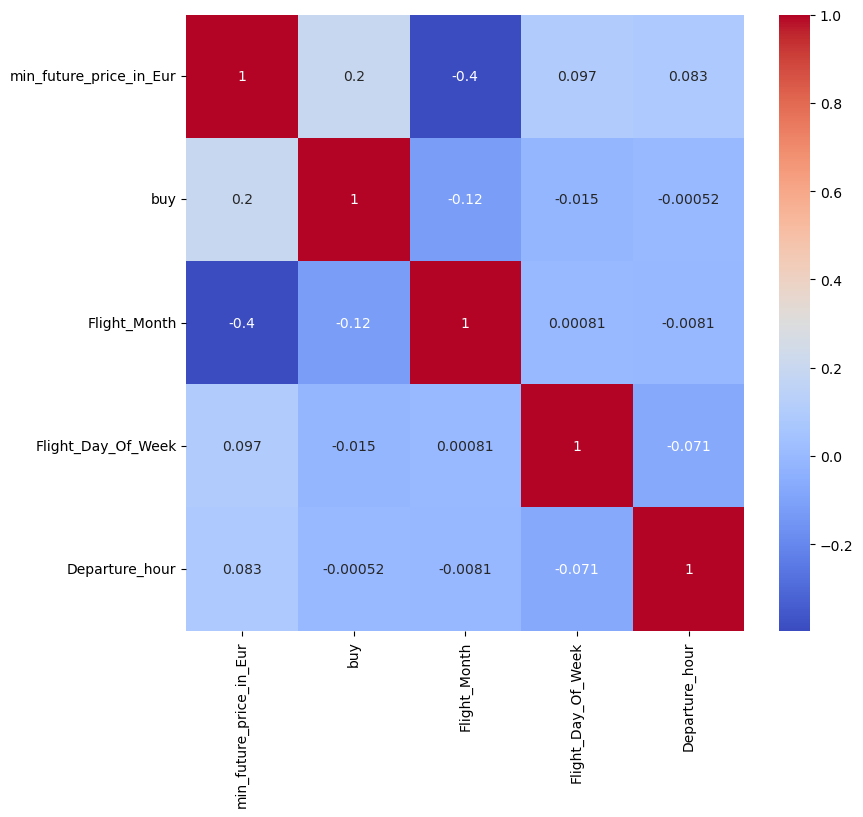

In [45]:
# Correlation matrix for min_future_price_in_eur, buy and the flight related columns
corr_matrix = df_train_copy[['min_future_price_in_Eur', 'buy', 'Flight_Month', 'Flight_Day_Of_Week', 'Departure_hour']].corr()

# plot the correlation matrix
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

-  -0.44 (strong negativ correlation): min_future_price_in_eur and Flight_month
-  -0.12 (negativ correlation): buy and Flight_month
-  0.097 (small positive correlation): Flight_day_of_week and min_future_price_in_eur
-  0.083 (small positive correlation): Departure_hour and min_future_price_in_eur

#### (Aktuell noch Route_Abb)Correlations for Categorical Variables ####

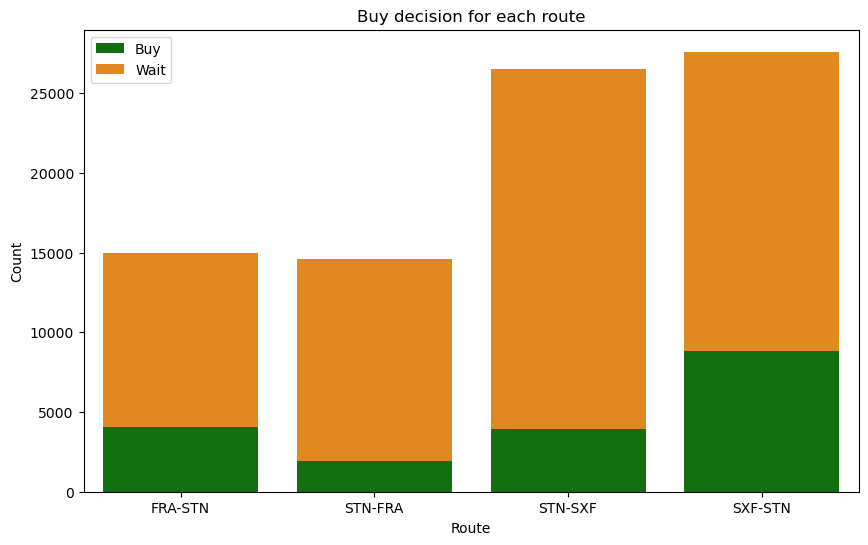

In [46]:
# Check the correlation between route_abb and the target variable 'buy'
buy_route_counts = df_train_copy.groupby(['route_abb', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[1], label='Buy', color='g')
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[0], bottom=buy_route_counts[1], label='Wait', color='darkorange')

plt.xlabel('Route')
plt.ylabel('Count')
plt.title('Buy decision for each route')
plt.legend()
plt.show()

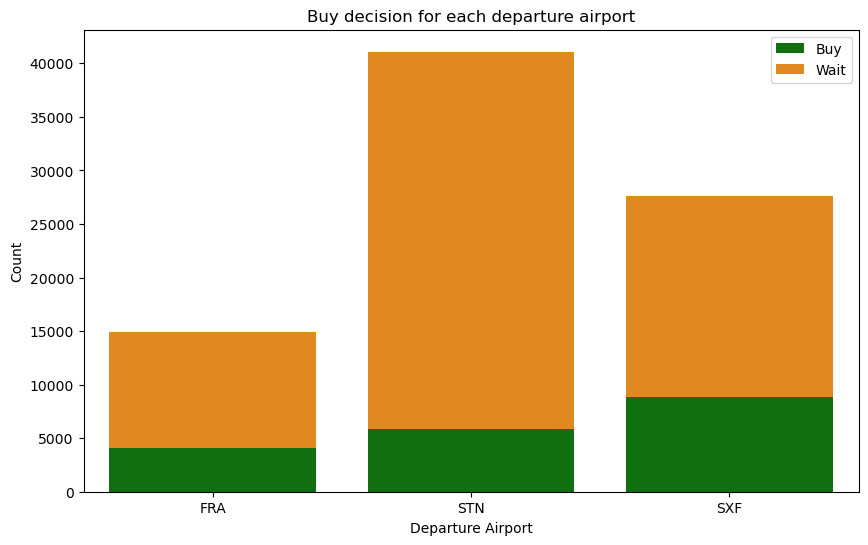

In [47]:
# check the correlation between departure_airport and the target variable 'buy'
buy_dep_airport_counts = df_train_copy.groupby(['Departure_airport', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=buy_dep_airport_counts.index, y=buy_dep_airport_counts[1], label='Buy', color='g')
sns.barplot(x=buy_dep_airport_counts.index, y=buy_dep_airport_counts[0], bottom=buy_dep_airport_counts[1], label='Wait', color='darkorange')

plt.xlabel('Departure Airport')
plt.ylabel('Count')
plt.title('Buy decision for each departure airport')
plt.legend()
plt.show()

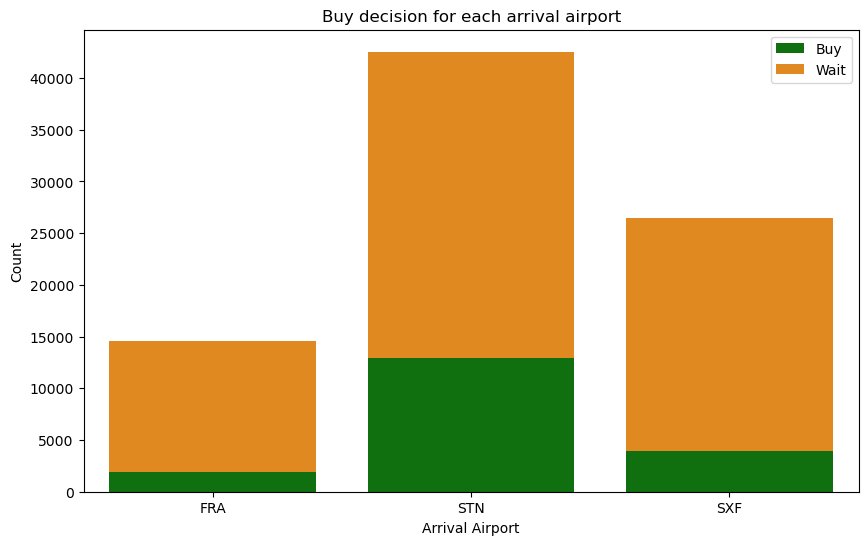

In [48]:
# check the correlation between arrival_airport and the target variable 'buy'
buy_arr_airport_counts = df_train_copy.groupby(['Arrival_airport', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=buy_arr_airport_counts.index, y=buy_arr_airport_counts[1], label='Buy', color='g')
sns.barplot(x=buy_arr_airport_counts.index, y=buy_arr_airport_counts[0], bottom=buy_arr_airport_counts[1], label='Wait', color='darkorange')

plt.xlabel('Arrival Airport')
plt.ylabel('Count')
plt.title('Buy decision for each arrival airport')
plt.legend()
plt.show()

There seems to be no big influence of the departure and arrival airport on the buy decision. Therefore we will not use the departure and arrival airport in the model.

In [49]:
# remove 'departure_airport' and 'arrival_airport' from the data
df_train_copy.drop(['Departure_airport', 'Arrival_airport'], axis=1, inplace=True)

### Select most important features ###

Additionally to the correlation matrix, we will now use a method to find the most important features for the model based on the results of SelectKBest.

#### SelectKBest for Regression ####

In [50]:
# feature selection with sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression 

# copy the data
df_train_copy2 = df_train_copy.copy()

# separate the features and the target variable 'min_future_price_in_Eur'
X = df_train_copy2.drop(['min_future_price_in_Eur', 'Request_Date', 'Flight_Date', 'index', 'flight_unique_id'], axis=1)
y = df_train_copy2['min_future_price_in_Eur']

# convert the categorical columns to numerical
X = pd.get_dummies(X)

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_regression, k=16) # 16 features
fit = bestfeatures.fit(X, y)

# create a dataframe with the scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# print the 10 best features
featureScores.nlargest(16, 'Score')


,Specs,Score
1,Price_In_Eur,2.812369
0,Departure_hour,0.792759
8,Flight_Day_Of_Week,0.655121
9,days_between_request_and_flight,0.564610
7,Flight_Month,0.562803
14,route_abb_STN-SXF,0.502119
15,route_abb_SXF-STN,0.448499
3,Request_Month,0.359292
13,route_abb_STN-FRA,0.342312
12,route_abb_FRA-STN,0.280657


It seems that the 10 most promising columns for predicting the minimum future price are:
-  Price_In_Eur
-  Departure_hour
-  Flight_Day_Of_Week
-  days_between_request_and_flight
-  Flight_Month
-  route_abb_STN-SXF
-  route_abb_SXF-STN
-  Request_Month
-  route_abb_STN-FRA
-  route_abb_FRA-STN

These results align with the results from the correlation matrixes. This means following features will be used in the model:
-  *Price_In_Eur*
-  *Departure_hour*
-  *Flight_Day_Of_Week*
-  *days_between_request_and_flight*
-  *Flight_Month*
-  *route_abb* (OneHotEncoded)
-  *Request_Month*

#### SelectKBest for Classification ####

In [51]:
# feature selection with sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif 

# copy the data
df_train_copy3 = df_train_copy.copy()

# separate the features and the target variable 'min_future_price_in_Eur'
X = df_train_copy3.drop(['buy', 'Request_Date', 'Flight_Date', 'index', 'flight_unique_id'], axis=1)
Y = df_train_copy3['buy']

print(df_train_copy3.columns)

# convert the categorical columns to numerical
X = pd.get_dummies(X)

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif , k=16)
fit = bestfeatures.fit(X, Y)

# create a dataframe with the scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# print the 10 best features
featureScores.nlargest(16, 'Score')


Index(['index', 'Request_Date', 'Flight_Date', 'Departure_hour',
       'flight_unique_id', 'route_abb', 'Price_In_Eur',
       'min_future_price_in_Eur', 'buy', 'Request_Month',
       'Request_Day_Of_Week', 'Request_is_Weekend', 'Request_Hour',
       'Flight_Month', 'Flight_Day_Of_Week', 'days_between_request_and_flight',
       'is_holiday', 'price_trend'],
      dtype='object')


,Specs,Score
2,min_future_price_in_Eur,0.082809
1,Price_In_Eur,0.079143
9,days_between_request_and_flight,0.035993
3,Request_Month,0.015542
0,Departure_hour,0.014011
15,route_abb_SXF-STN,0.014004
7,Flight_Month,0.012917
10,is_holiday,0.009964
14,route_abb_STN-SXF,0.009533
11,price_trend,0.009001


## Prepare the data (Data Preparation) ##

In [52]:
# copy the data again from the original dataframe
df_train_copy = df_train.copy()

### 1. Data cleaning ###

-  No removing of outliers, because there are no outliers in the data.
-  No filling of missing values, because there are no missing values in the data.

### 2. Feature selection ###

We will now select the features that we may want to use for the model. We will try out different combinations of features and see which combination gives the best results.

-  Remove *index* because it is not needed anymore.

In [53]:
# drop the columns that are not needed
df_train_copy.drop(['index'], axis=1, inplace=True)

### 3. Feature Engineering ###

-  Encode *route_abb* with OneHotEncoder.
-  Convert *Request_date* and *Flight_date* to datetime. Remove timezone information from *Request_date*.
-  Create *days_between_request_and_flight_date* from *Request_date* and *Flight_date*.
-  Create *Request_Month* from *Request_date*. Then remove *Request_date*.
-  Create *Flight_Month* and *Flight_Day_Of_Week* from *Flight_date*. Then remove *Flight_date*.

In [54]:
# One hot encoding for route_abb
df_train_copy = pd.get_dummies(df_train_copy, columns=['route_abb'], prefix = ['route_abb'])

In [55]:
# convert Request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# convert Flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

In [56]:
# create column days_between_request_and_flight
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

In [57]:
# create column 'is_holiday'
df_train_copy['is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_uk_ger)

In [58]:
# create column 'is_weekend'
df_train_copy['is_weekend'] = df_train_copy['Request_Date'].dt.weekday >= 5

In [59]:
# create column Flight_month
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

# create column Flight_day_of_week
df_train_copy['Flight_Day_Of_Week'] = df_train_copy['Flight_Date'].dt.dayofweek

# remove the Flight_Date column
df_train_copy.drop(['Flight_Date'], axis=1, inplace=True)

In [60]:
# create Request_Month column
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

# remove the Request_Date column
df_train_copy.drop(['Request_Date'], axis=1, inplace=True)

In [61]:
# create column 'price_trend'
price_trend(df_train_copy)
# delete the column 'rolling_mean_price' and 'avg_price_difference'
df_train_copy.drop(['rolling_mean_price', 'avg_price_difference'], axis=1, inplace=True)

In [62]:
# delete the column 'flight_unique_id'
df_train_copy.drop(['flight_unique_id'], axis=1, inplace=True)

In [63]:
# check the new df_train_price dataframe
df_train_copy.head()

,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy,route_abb_FRA-STN,route_abb_STN-FRA,route_abb_STN-SXF,route_abb_SXF-STN,days_between_request_and_flight,is_holiday,is_weekend,Flight_Month,Flight_Day_Of_Week,Request_Month,price_trend
0,19,208.07,259.07,1,0,0,0,1,1,0,False,6,2,6,0
1,19,259.07,259.07,1,0,0,0,1,1,0,False,6,2,6,0
2,19,259.07,259.07,1,0,0,0,1,0,0,False,6,2,6,1
3,19,259.07,259.07,1,0,0,0,1,0,0,False,6,2,6,0
4,21,143.86,251.72,1,0,0,1,0,1,0,False,6,2,6,0


We now have the following features for the target variable *min_future_price_in_eur* and *buy*:
-  *Price_In_Eur*
-  *Request_Month*
-  *Departure_hour*
-  *Flight_Day_Of_Week*
-  *days_between_request_and_flight*
-  *Flight_Month*
-  *route_abb* (OneHotEncoded)

### 4. Feature scaling ###

-  Maybe the model will perform better with feature scaling, so we will try it. The features are scaled in the next section.

## Try out different models and find the best ones (Model Selection) ##

### Buy as target variable ###

##### Define the target variable and the features ##### 

In [64]:
# No. 1 Define the features and the target
# X = df_train_copy[['Price_In_Eur', 'Request_Month', 'Flight_Day_Of_Week', 'Departure_hour',
#     'days_between_request_and_flight', 'Flight_Month', 'route_abb_FRA-STN', 'route_abb_STN-FRA', 'route_abb_STN-SXF', 'route_abb_SXF-STN', 'price_trend']]
# y = df_train_copy['buy']

# No. 2 Define the features and the target
X = df_train_copy[['Price_In_Eur', 'Flight_Day_Of_Week', 'Departure_hour',
    'days_between_request_and_flight', 'is_holiday', 'is_weekend', 'price_trend', ]]
y = df_train_copy['buy']

X_data_loss_calculation = df_train_copy['min_future_price_in_Eur']

# Split the data into train and test data
X_train, X_test, y_train, y_test, X_data_loss_calculation_train, X_data_loss_calculation_test = train_test_split(X, y, X_data_loss_calculation, test_size=0.2, random_state=42)

##### Define Helper Functions for the Model Training and Evaluation #####

In [65]:
# Create a function to calculate the metrics
def calculate_metrics(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('ROC AUC: ', roc_auc_score(y_test, y_pred))

# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Create a function to plot the Learning Curve
def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Create a function to plot the ROC Curve
def plot_roc_curve(estimator, X, y, cv=5):
    # Compute probabilities
    y_pred_prob = estimator.predict_proba(X_test)[:,1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure()
    lw = 2  # line width
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# create a function to calculate the loss based on the predictions
def calculate_loss(predictions, X_data, y_train, X_data_loss):
     # Initialize loss to 0
    fn_loss = 0
    fp_loss = 0

    tp_gain = 0
    tn_gain = 0

    # For each prediction
    for i in range(len(predictions)):
        # If the model incorrectly predicts "do not buy"
        if predictions[i] == 0 and y_train.iloc[i] == 1:
            # Calculate the loss as the difference between the min future price and the current price
            fn_loss += X_data_loss.iloc[i] - X_data.iloc[i]['Price_In_Eur']
        # If the model incorrectly predicts "buy"
        elif predictions[i] == 1 and y_train.iloc[i] == 0:
            # Calculate the loss as the difference between the current price and the min future price
            fp_loss += X_data.iloc[i]['Price_In_Eur'] - X_data_loss.iloc[i]
        # If the model correctly predicts "buy"
        elif predictions[i] == 1 and y_train.iloc[i] == 1:
            # Calculate the gain as the difference between the min future price and the current price
            tp_gain += X_data_loss.iloc[i] - X_data.iloc[i]['Price_In_Eur']
        # If the model correctly predicts "do not buy"
        elif predictions[i] == 0 and y_train.iloc[i] == 0:
            # Calculate the gain as the difference between the current price and the min future price
            tn_gain += X_data.iloc[i]['Price_In_Eur'] - X_data_loss.iloc[i]
            

    # Calculate total cost
    total_cost = tn_gain + fn_loss + tp_gain + fp_loss

    # print the total cost
    print('Total Cost: ', total_cost, '€')
    
    # print the loss in €
    print('False Positive Loss: ', fp_loss, '€')
    print('False Negative Loss: ', fn_loss, '€')

    # print the gain in €
    print('True Positive Gain: ', tp_gain, '€')
    print('True Negative Gain: ', tn_gain, '€')

    # plot the loss and gain
    plt.bar(['False Positive Loss', 'False Negative Loss', 'True Positive Gain', 'True Negative Gain'], [fp_loss, fn_loss, tp_gain, tn_gain])
    plt.xticks(rotation=45)
    plt.ylabel('€')
    plt.show()


#### Scaling ####

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#### Random Forest Classifier ####

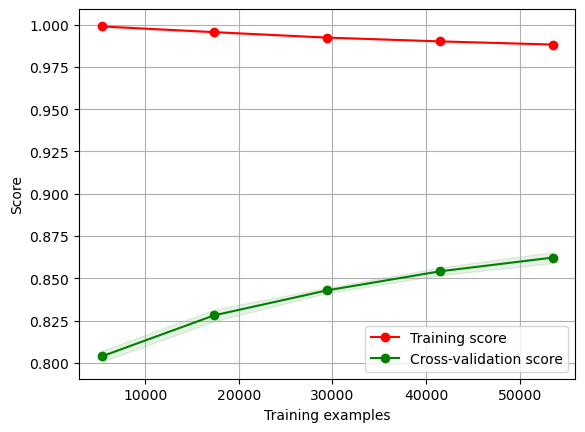

Accuracy:  0.9863525613237866
Precision:  0.9788424788424789
Recall:  0.9596520575443293
F1:  0.9691522789471905
ROC AUC:  0.9768426203724265


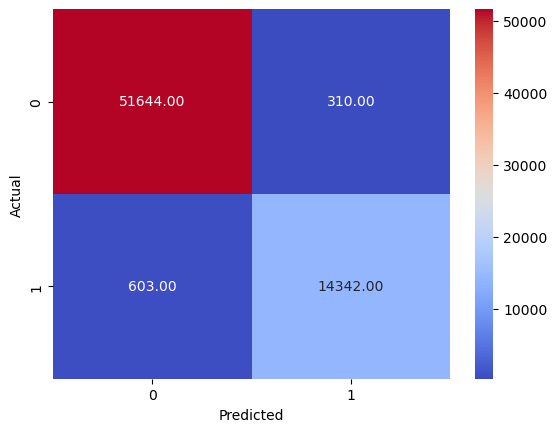

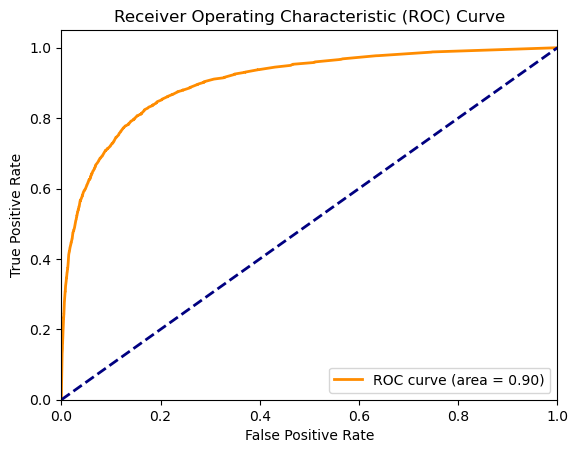

In [73]:
# Train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# train classifier with configuration (Ergebnis GridSearch) : {'max_depth': 15,'min_samples_leaf': 1,'min_samples_split': 2,'n_estimators': 100}
# rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=10, random_state=42)

rfc.fit(X_train, y_train)
plot_learning_curve(rfc, X_train, y_train)
calculate_metrics(y_train, rfc.predict(X_train))
plot_confusion_matrix(y_train, rfc.predict(X_train))
plot_roc_curve(rfc, X_train, y_train)

In [68]:
# optimize the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train) 
grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

#### Logistic Regression ####

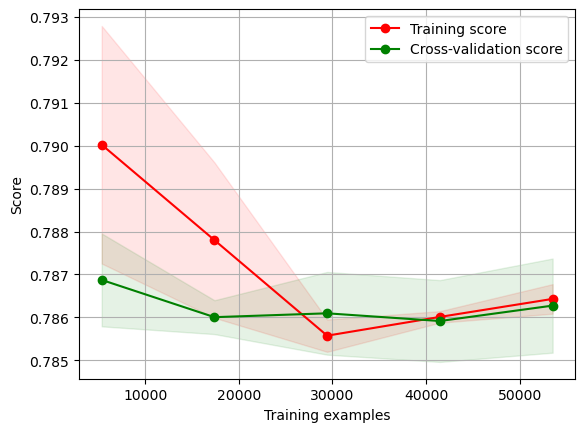

Accuracy:  0.7863944154621145
Precision:  0.6407391491190374
Recall:  0.09976580796252928
F1:  0.17264937471051414
ROC AUC:  0.541837325200035


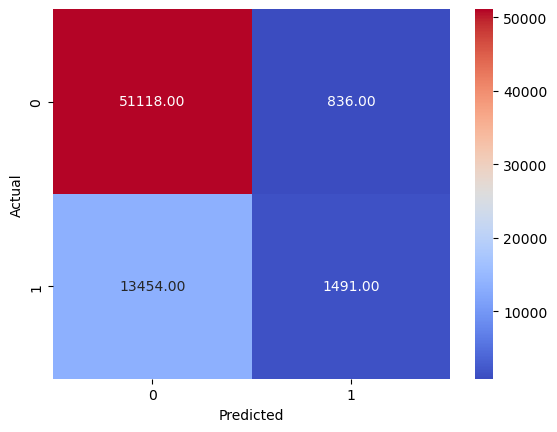

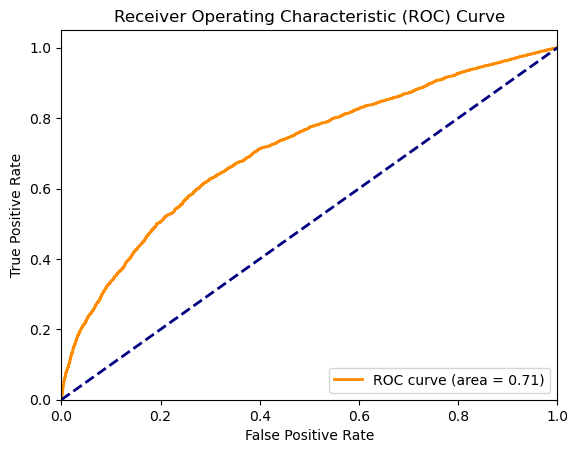

In [69]:
# Train a Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lr.fit(X_train, y_train)
plot_learning_curve(lr, X_train, y_train)
calculate_metrics(y_train, lr.predict(X_train))
plot_confusion_matrix(y_train, lr.predict(X_train))
plot_roc_curve(lr, X_train, y_train)

In [70]:
# optimize the hyperparameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'C': 10, 'penalty': 'l1'}

#### Decision Tree Classifier ####

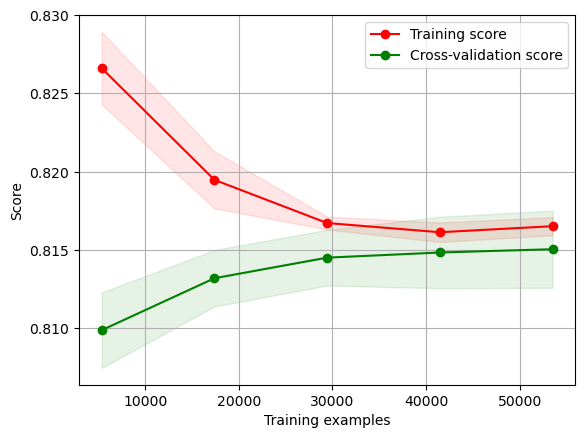

Accuracy:  0.8158567392636661
Precision:  0.7235274089206674
Recall:  0.28437604550016726
F1:  0.4082808972573131
ROC AUC:  0.6265588122946808


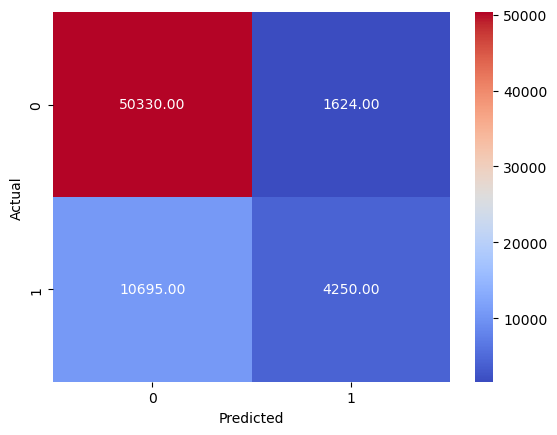

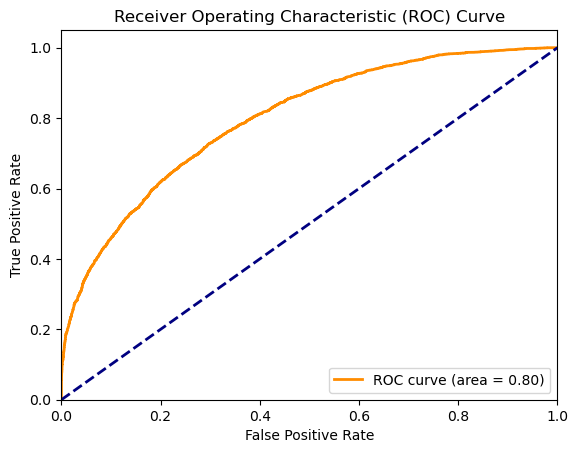

In [71]:
# Train a Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
plot_learning_curve(gbc, X_train, y_train)
calculate_metrics(y_train, gbc.predict(X_train))
plot_confusion_matrix(y_train, gbc.predict(X_train))
plot_roc_curve(gbc, X_train, y_train)

In [72]:
# Optimize the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: 

#### Support Vector Machine Classifier ####

In [ ]:
# Train a Support Vector Machine Classifier
# from sklearn.svm import SVC

# svc = SVC(random_state=42)
# svc.fit(X_train, y_train)
# plot_learning_curve(svc, X_train, y_train)
# calculate_metrics(y_train, svc.predict(X_train))
# plot_confusion_matrix(y_train, svc.predict(X_train))
# plot_roc_curve(svc, X_train, y_train)

In [ ]:
# optimize the hyperparameters
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'gamma': ['scale', 'auto'],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
# }

# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

#### K-Nearest Neighbors Classifier ####

d:\Programme\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
d:\Programme\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

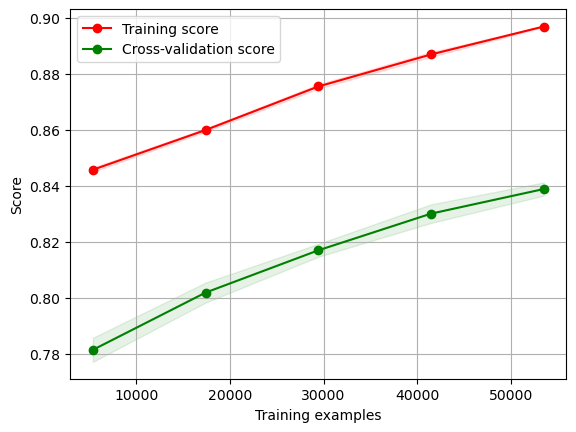

d:\Programme\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy:  0.904333398107595
Precision:  0.8481786325482846
Recall:  0.6964202074272332
F1:  0.7648442092886538
ROC AUC:  0.8302807816209963


d:\Programme\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


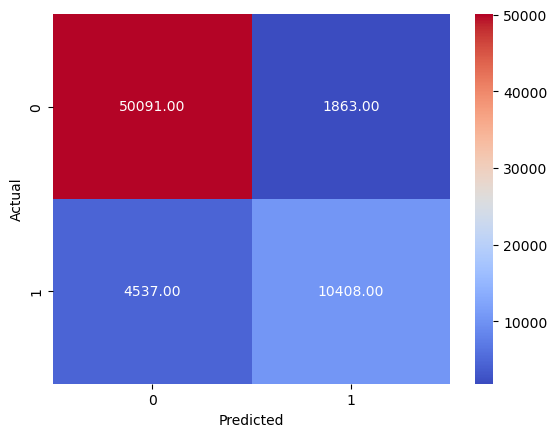

In [ ]:
# Train a K-Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
plot_learning_curve(knn, X_train, y_train)
calculate_metrics(y_train, knn.predict(X_train))
plot_confusion_matrix(y_train, knn.predict(X_train))
plot_roc_curve(knn, X_train, y_train)

In [ ]:
# optimize the hyperparameters
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_

#### Gaussian Naive Bayes Classifier ####

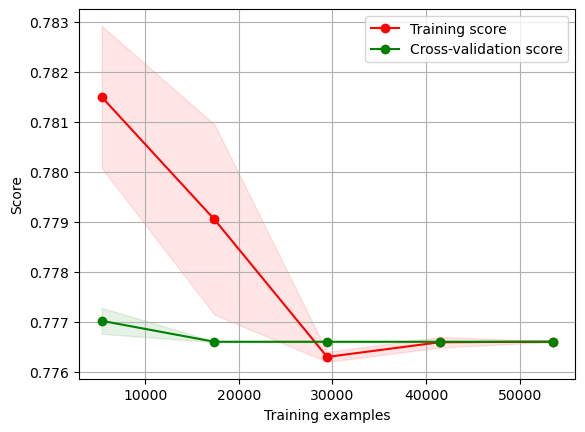

Accuracy:  0.7766035366746887
Precision:  0.0
Recall:  0.0
F1:  0.0
ROC AUC:  0.5


d:\Programme\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


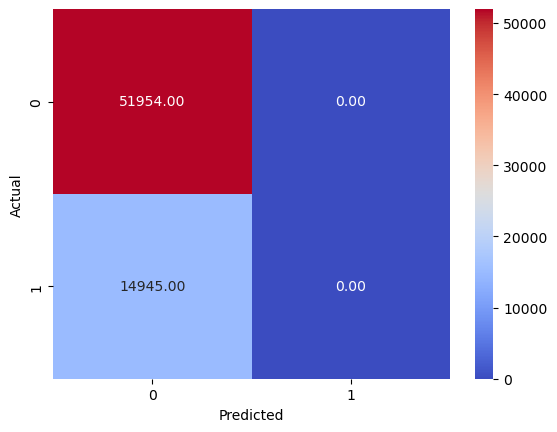

In [ ]:
# Train a Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
plot_learning_curve(gnb, X_train, y_train)
calculate_metrics(y_train, gnb.predict(X_train))
plot_confusion_matrix(y_train, gnb.predict(X_train))
plot_roc_curve(gnb, X_train, y_train)

In [ ]:
# optimize the hyperparameters
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_